<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
from sqlite3 import connect
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [80]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

# 1 | Préparation des données

In [81]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")

In [82]:
data.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,1,18040,good (silver)


In [109]:
data.describe()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch_day_of_week,customer_zip_code_prefix
count,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000
mean,236.936673,1.033420,176.460376,6.074306,265.181315,4.126214,1.139511,1.037352,2.756033,35241.436111
std,152.584315,0.209099,281.875843,1.729592,111.970086,1.319043,0.527042,0.220850,1.967601,29842.837938
min,0.000000,1.000000,9.590000,3.000000,111.000000,0.000000,1.000000,1.000000,0.000000,1003.000000
25%,113.000000,1.000000,63.100000,5.000000,211.000000,4.000000,1.000000,1.000000,1.000000,11410.000000
50%,218.000000,1.000000,108.410000,6.000000,311.000000,5.000000,1.000000,1.000000,3.000000,24452.000000
75%,345.000000,1.000000,186.950000,7.000000,411.000000,5.000000,1.000000,1.000000,4.000000,59075.000000
max,694.000000,15.000000,18623.520000,12.000000,444.000000,5.000000,21.000000,8.000000,6.000000,99980.000000


In [98]:
pca_2d_dict =  {}
pca_3d_dict =  {}
tsne_2d = {}
tsne_3d = {}

def find_best_k(data):
  """
  Cette fonction permet d'estimer le meilleur k (nombre de cluster optimal) pour un dataset donné.
  data: dataframe
  return: silhouette_scores, dict_kmeans, best_silhouette_k
  """
  silhouette_scores = {}
  dict_kmeans = {}

  for k in range(2, 15):
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      cluster_labels = kmeans.predict(data)
      silhouette_scores[k] = silhouette_score(data, cluster_labels, n_jobs=-1)
      dict_kmeans[k] = kmeans

  best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
  print(f"best_k={best_silhouette_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")
  return silhouette_scores, dict_kmeans, best_silhouette_k


def plot_silhouette_scores(data, silhouette_scores, best_silhouette_k):
  fig, axes = plt.subplots(1, 2, figsize=(18,5))

  axes[0].plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
  axes[0].axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  axes[0].set_xlabel("Nombre de clusters (k)")
  axes[0].set_ylabel("Silhouette Score")
  axes[0].set_xlabel("Nombre de clusters (k)")
  axes[0].set_ylabel("Silhouette Score")
  axes[0].set_title("Score de silhouette en fonction de k")
  axes[0].legend()


  visualizer = SilhouetteVisualizer(estimator=KMeans(random_state=42), k=(2, 25))

  visualizer.fit(data)    # Fit the data to the visualizer
  visualizer.poof(ax=axes[1])

  plt.show()

def plot_clusters(labels, X_pca_2d=None, X_pca_3d=None):
  # Visualiser les résultats
  fig = plt.figure(figsize=(16, 8))

  cmap = mpl.colormaps.get_cmap('coolwarm')

  # Visualiser les résultats
  if X_pca_2d is not None:
    ax1 = fig.add_subplot(2,2,1)
    ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax1.set_title('K-means Clustering with PCA 2D Visualization')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')

  if X_pca_3d is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with PCA 3D Visualization')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel("PC3")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)



  '''if X_tsne is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 3D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
    ax.set_zlabel("t-SNE3")

    ax = fig.add_subplot(2,2,4)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 2D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
  '''

  plt.show()


def get_pca(dim=2, selection='full', df=None):
  """
  dim: int => dimension de la projection
  selection: str => full ou rfm
  df: dataframe => dataframe à utiliser pour la projection
  return: X_pca
  """
  if selection == 'full':
    if dim == 2:
      if pca_2d_dict.get('full') is not None:
        return pca_2d_dict['full']
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get('full') is not None:
        return pca_3d_dict['full']
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")
  else:
    if dim == 2:
      if pca_2d_dict.get(selection) is not None:
        return pca_2d_dict[selection]
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get(selection) is not None:
        return pca_3d_dict[selection]
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")

# 2 | prévalence de la loyauté des clients

La segmentation RFM (Récence, Fréquence, Montant) nous a permis d’évaluer la fidélité des clients et de les classer en quatre segments distincts :  

1. **Gold (Clients Premium)** : Ces clients affichent des scores RFM élevés, indiquant une activité récente, une fréquence d’achat soutenue et des montants de dépenses significatifs. Ils représentent les clients les plus précieux.  

2. **Silver (Clients Loyaux)** : Ce segment regroupe les clients ayant un score élevé sur au moins un des trois critères (récence, fréquence ou montant). Ils sont engagés mais pourraient être encore plus valorisés.  

3. **Bronze (Clients à Risque)** : Ces clients montrent des signes de désengagement, avec une baisse de la fréquence ou de la récence de leurs achats. Il est essentiel d’anticiper leur attrition en mettant en place des actions ciblées.  

4. **Inactive (Clients Perdus)** : Ce segment comprend les clients inactifs depuis une période prolongée. Une stratégie de réactivation peut être envisagée pour les inciter à revenir.  

Cette segmentation permet d’optimiser les actions marketing en adaptant les stratégies d’engagement et de rétention en fonction du profil de chaque client.

In [83]:
rfm_counts = data['rfm_segment_loyalty'].value_counts()

fig = px.pie(
    rfm_counts,
    values=rfm_counts.values,
    names=rfm_counts.index,
    title="Distribution des client par segment de Loyalty",
    hole=0
    )
fig.update_traces(textinfo="label+percent", textfont_size=12, rotation=90)
fig.update_layout(showlegend=True, legend_title_text="Segment de Loyalty")
fig.show()

# 3 | Standardisation des données

In [85]:
data_ = data.copy()
customer_unique_id = data.customer_unique_id
data_.drop(columns=['customer_unique_id', 'last_purch', 'rfm_segment', 'rfm_segment_loyalty', 'customer_zip_code_prefix', 'last_purch_day_of_week'], inplace=True)
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(data_), columns=data_.columns)

In [86]:
X_scaled.head()

,recency,frequency,monetary,rfm_score,satisfaction,nbre_items,distinct_products
0,-0.825362,-0.15983,-0.122609,1.113386,0.662443,-0.264706,-0.169129
1,-0.805701,-0.15983,-0.529564,-0.042962,-0.095686,-0.264706,-0.169129
2,1.959998,-0.15983,-0.320144,-1.199310,-0.853816,-0.264706,-0.169129
3,0.544379,-0.15983,-0.471275,-1.199310,-0.095686,-0.264706,-0.169129
4,0.328104,-0.15983,0.072478,0.535212,0.662443,-0.264706,-0.169129


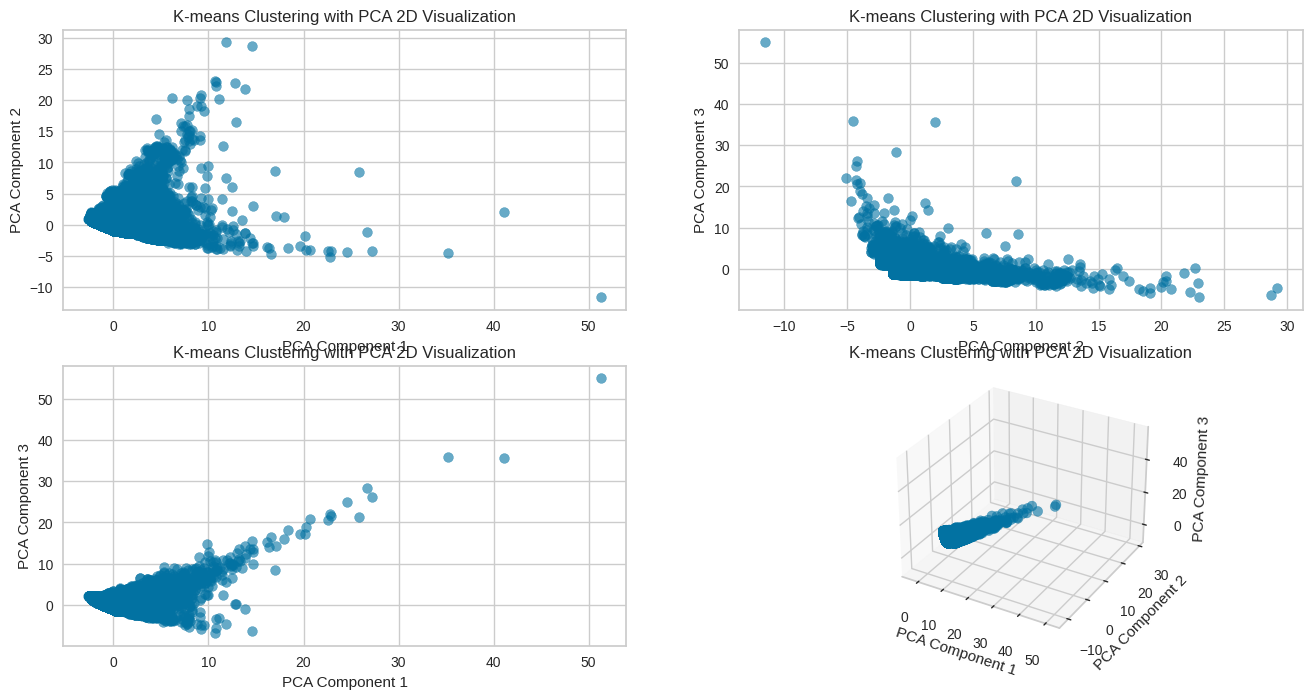

In [124]:
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('coolwarm')

X_pca = PCA(n_components=3).fit_transform(X_scaled)

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

ax1 = fig.add_subplot(2,2,2)
ax1.scatter(X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 2')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(X_pca[:, 0], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,4, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')

plt.show()

# 4 | K-Means Clustering

In [76]:
kmeans_data = X_scaled.copy()

In [77]:
kmeans_data.head()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products
0,-0.825362,-0.15983,-0.122609,1.113386,1.320169,0.662443,-0.264706,-0.169129
1,-0.805701,-0.15983,-0.529564,-0.042962,1.302307,-0.095686,-0.264706,-0.169129
2,1.959998,-0.15983,-0.320144,-1.199310,-1.368063,-0.853816,-0.264706,-0.169129
3,0.544379,-0.15983,-0.471275,-1.199310,-0.483894,-0.095686,-0.264706,-0.169129
4,0.328104,-0.15983,0.072478,0.535212,-0.457101,0.662443,-0.264706,-0.169129


In [78]:
kmeans_data.head()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products
0,-0.825362,-0.15983,-0.122609,1.113386,1.320169,0.662443,-0.264706,-0.169129
1,-0.805701,-0.15983,-0.529564,-0.042962,1.302307,-0.095686,-0.264706,-0.169129
2,1.959998,-0.15983,-0.320144,-1.199310,-1.368063,-0.853816,-0.264706,-0.169129
3,0.544379,-0.15983,-0.471275,-1.199310,-0.483894,-0.095686,-0.264706,-0.169129
4,0.328104,-0.15983,0.072478,0.535212,-0.457101,0.662443,-0.264706,-0.169129


## | 4.1 clustering avec les features rfm seulement

In [87]:
feats = ['recency', 'frequency', 'monetary', 'rfm_segment', 'satisfaction', 'rfm_score']
first_selection_df = kmeans_data[feats]

### 4.1.1 | recherche du k optimal

In [88]:
%%time
silhouette_scores, dict_kmeans, best_silhouette_k = find_best_k(first_selection_df.values)

best_k=2, best_silhouette_k=0.35777673945031524
CPU times: user 1h 2min 42s, sys: 9min 49s, total: 1h 12min 31s
Wall time: 55min 14s


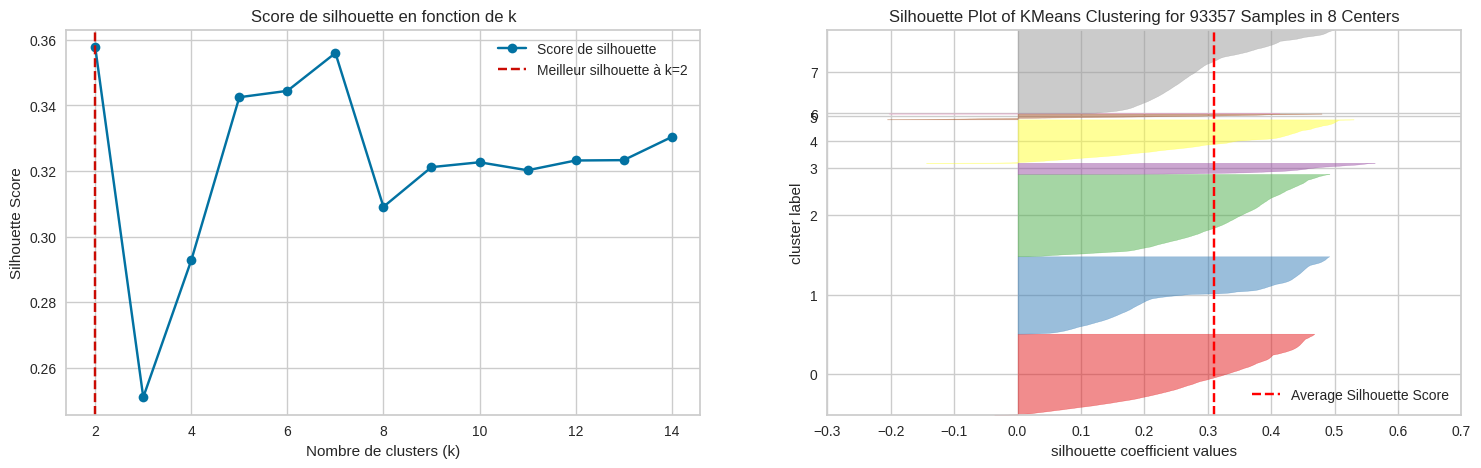

In [89]:
plot_silhouette_scores(first_selection_df, silhouette_scores, best_silhouette_k)

### 4.1.2 | Kmean avec  k=2

In [125]:
%%time
kmeans = KMeans(n_clusters=2, random_state=42).fit(first_selection_df)
labels = kmeans.labels_
first_selection_df["cluster"] = labels

#sns.pairplot(first_selection_df, hue="cluster")
#plt.show()

CPU times: user 82 ms, sys: 20.4 ms, total: 102 ms
Wall time: 83 ms


<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
%%time
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='rfm', df=first_selection_df)
pca_3d, X_pca_3d = get_pca(dim=3, selection='rfm', df=first_selection_df)

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 68.64547953592732
---------------------------------------------
Les trois dimensions capture 85.33113951038824


CPU times: user 29.8 ms, sys: 9.96 ms, total: 39.7 ms
Wall time: 22.8 ms


In [30]:
pca_3d.explained_variance_ratio_

array([0.90097358, 0.0421579 , 0.02467601])

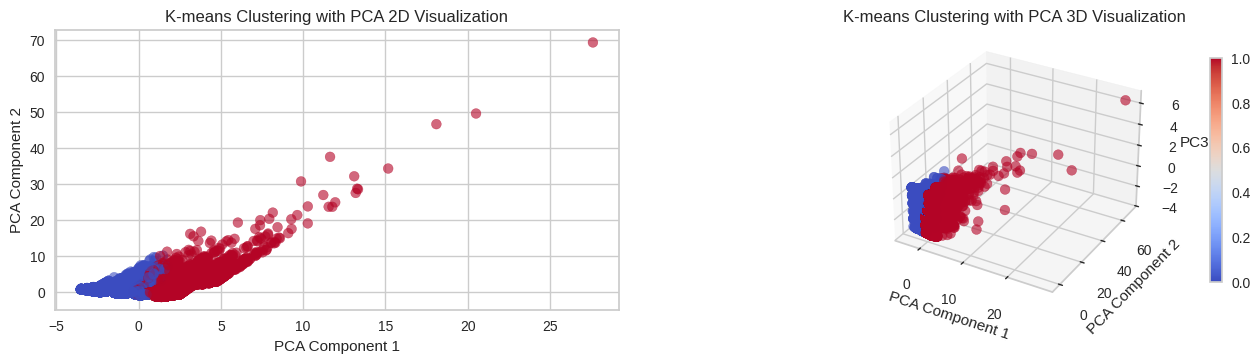

In [126]:
# Visualiser les résultats en 3D et 2D
plot_clusters(labels, X_pca_2d, X_pca_3d)

## | 4.2 clustering avec l'ensemble des features

In [127]:
X = kmeans_data.copy()

### 4.2.1 | recherche du k optimal

In [128]:
%%time
silhouette_scores_2, dict_kmeans_2, best_silhouette_k_2 = find_best_k(X)

best_k=4, best_silhouette_k=0.36654230223318107
CPU times: user 1h 16min 41s, sys: 9min 53s, total: 1h 26min 35s
Wall time: 1h 5min 46s


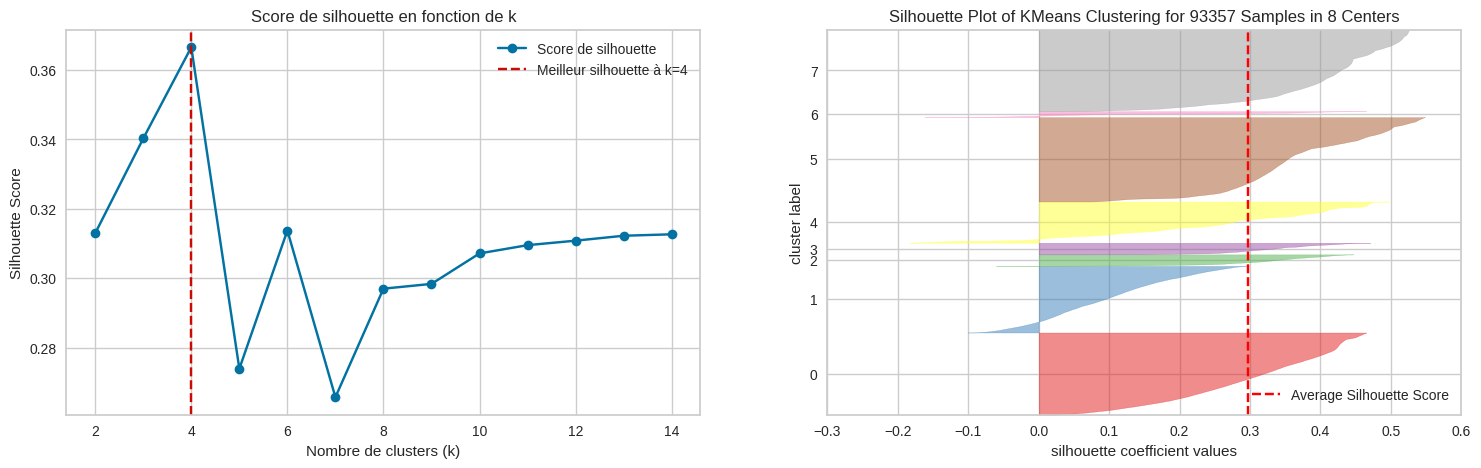

In [129]:
plot_silhouette_scores(X, silhouette_scores_2, best_silhouette_k_2)

### 4.2.2 | Kmean avec  k=

In [130]:
%%time
kmeans_2 = KMeans(n_clusters=best_silhouette_k_2, random_state=42).fit(X)
labels_2 = kmeans_2.labels_

X_ = X.copy()
X_["cluster"] = labels

CPU times: user 120 ms, sys: 53 ms, total: 173 ms
Wall time: 107 ms


In [131]:
%%time
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='full', df=first_selection_df)
pca_3d, X_pca_3d = get_pca(dim=3, selection='full', df=first_selection_df)

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")X_pca_3d

Les trois dimensions capture 70.71767696960708


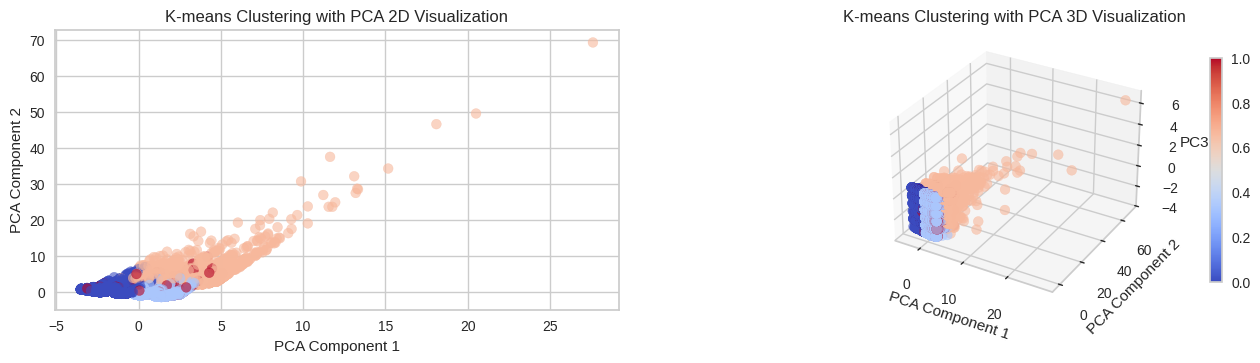

In [132]:
plot_clusters(labels_2, X_pca_2d, X_pca_3d)

In [ ]:
# Utilisation des radars plots pour une meilleure intrepretation des clusters

# 5 | DBscan Clustering

In [133]:
dbscan_data= X_scaled.copy()

In [134]:
dbscan = DBSCAN(eps=1, min_samples=5)
labels_dbscan = dbscan.fit_predict(dbscan_data)

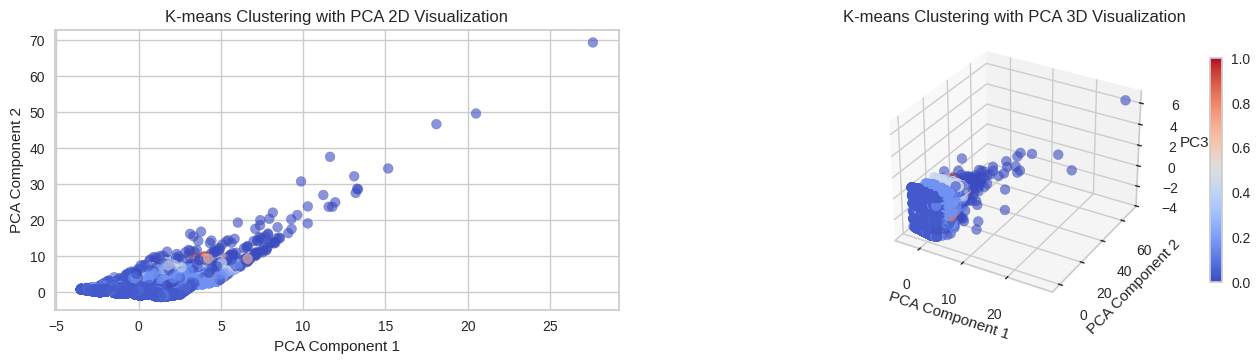

In [135]:
plot_clusters(labels_dbscan, X_pca_2d, X_pca_3d)

# 6 | Hierarchical Agglomerative Clustering (HAC)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hac = AgglomerativeClustering(n_clusters=k)
labels_hac = hac.fit_predict(X_scaled)